# The_Brobs Ex 4 
### Alessandro Fella
### Lorenzo Mandolito
### Lucia Depaoli
### Simone Mistrali

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [ ]:
def import_data(q, state, SPINS):
    fname = "DATA/dataRBM_q" + str(q) + "_" + str(state)+ "state.csv"
    print(fname)
    # Visible data
    v = np.loadtxt(fname,delimiter=",",dtype=int)
    N = len(v)
    # Length of sample
    L = len(v[0])
    print(f"Each of N={N} data samples has L={L} digits.")

    q = 0
    fname = "DATA/dataRBM_q" + str(q) + "_" + str(state) + "state.csv"
    # Visible data not corrupted
    v_true = np.loadtxt(fname,delimiter=",",dtype=int)

    # Choice of using -1/+1 and not 0,1
    if SPINS:
        vmin = -1
    # The energy gap now is 2 not 1
        GAP  = 2  
        v = 2*v -1
        v_true = 2*v -1
    else:
        vmin = 0
        GAP = 1

    # Store initial values
    v0 = np.zeros_like(v)
    v0[:] = v[:]


    for n in range(10):
        print(v[n])

    print("...")

    return v, v_true,v0, N, L, GAP, vmin

***Initially "bits" are been used with a corruption parameter q=0.1 and a number of hidden units M=3 ***

In [ ]:
v, v_true, v0, N, L, GAP, vmin = import_data(0.1, 3, False)

DATA/dataRBM_q0.1_3state.csv
Each of N=10000 data samples has L=8 digits.
[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]
...


In [ ]:
# Number of hidden units
M = 3

sigma = np.sqrt(4. /float(L + M))
np.random.seed(12345)

# Numbers in [-sigma;sigma]
w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)
print(f"w = {w}\na = {a}\nb = {b}")
w0,a0,b0 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
w0[:],a0[:],b0[:] = w[:],a[:],b[:]

w = [[ 0.5181365  -0.22145941 -0.38120826]
 [-0.35631371  0.08167946  0.11523125]
 [ 0.56022559  0.18473853  0.3001927 ]
 [ 0.18521223  0.2987553   0.55635686]
 [-0.59290602 -0.47464594 -0.24277246]
 [ 0.18863898  0.373648    0.44886104]
 [ 0.56038609  0.26977468  0.17183171]
 [ 0.26225893 -0.03907707 -0.21035279]]
a = [-0.07279134  0.27701546  0.59580401  0.21331772  0.35074515 -0.39689234
 -0.57064124  0.36226014]
b = [0. 0. 0.]


### Way to plots the Boltzmann machine

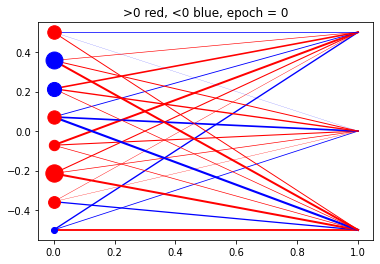

In [ ]:
def create_coord(np,x0):
    x = [x0] * np
    y = list(range(np))
    #y = y/(np - 1.) - .5
    for i in range(np):
            y[i] = y[i]/(np - 1.) - .5
    return(x,y)

(x1,y1) = create_coord(L,0)
(x2,y2) = create_coord(M,1)
             
def mycolor(val):
    if val>0:
        return "red"
    elif val<0:
        return "blue"
    return"black"

def plotgraph(w,a,b,epoch=0):
    A = 2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]), (y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))
    A = 300./(a.max() + b.max())
    # plot units
    for i in range(L):
        plt.scatter(x1[i],y1[i],s=A*np.abs(a[i]),zorder=2,c=mycolor(a[i]))
    A = 300./(a.max() + b.max())
    # plot units
    for j in range(M):
        plt.scatter(x2[j],y2[j],s=A*np.abs(b[j]),zorder=2,c=mycolor(b[j]))
    plt.title(f">0 red, <0 blue, epoch = {epoch}")
    plt.show()

plotgraph(w,a,b)

In [ ]:
def activate(v_in, wei, bias, DE, β = 1, info=False):
    act = np.dot(v_in,wei) + bias
    prob = 1. / (1. + np.exp(-DE * β * act))
    n = len(act)
    v_out = np.full(n,vmin)
    # Stochastic part
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print("input = ",v_in)
        print("act   = ",act)
        print("prob  = ",prob)
        print("out   = ",v_out)
    return (v_out)

activate(v[0],w,b,GAP,True)

array([0, 1, 0])

### Restricted Boltzmann Machine

In [ ]:
def RBM(w, v, a, b, M, nepoch = 50, mini = 500, l_rate = 1.0, plot = False, ev = False):
    m = 0
    ws  = np.zeros_like(w)
    asa = np.zeros_like(a)
    bs  = np.zeros_like(b)
    ws[:]  = w[:]
    asa[:] = a[:]
    bs[:]  = b[:]
    mean_mean_dw = []
    for epoch in range(1,nepoch+1):
        mean_dw = []
        for n in range(N):
            if m==0:
                # initialize the minibatch
                v_data, v_model   = np.zeros(L), np.zeros(L)
                h_data, h_model   = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))

            # Positive CD phase
            h  = activate(v[n],ws,bs,GAP)
            # Negative CD phase
            vf = activate(h,ws.T,asa,GAP)
            # Positive CD phase nr 2
            hf = activate(vf,ws,bs,GAP)

            v_data  += v[n]
            v_model += vf
            h_data  += h                
            h_model += hf

            vh_data  += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1

            if m==mini:
                C  = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C*(h_data - h_model)
                # if epoch <=2 and n>=mini:
                #     print("--- epoch = ",epoch, "   n = ",n, "    m = ",m)
                #     print("dw = ",dw)
                #     print("da = ",da)
                #     print("db = ",db)

                ws += dw
                asa += da
                bs += db
                m = 0

                if ev:
                    mean_dw.append(np.sum(dw**2) / (L*M))
        if ev:            
            mean_mean_dw.append(np.mean(mean_dw))
            

        # randomize order
        np.random.shuffle(v)
        l_rate = l_rate /(0.05 * l_rate + 1) 
        if plot:
            if epoch %5 ==0:
                plotgraph(ws,asa,bs,epoch)
                print("l_rate = ",l_rate)
    return ws,asa,bs,mean_mean_dw

In [ ]:
def comparison(x, x_true, pix):
    """
    Input:
        x -> Vector to compare
        x_true -> True vector
        pix -> pixel of confident
    Output:
        c/N -> rateo of pattern retrived by the algorithm
    """
    # x = np.asarray(x)
    # x_true = np.asarray(x_true)
    N = x.shape[0]
    K = x.shape[1]
    #print(N)
    #print(K)
    if (x.shape != x_true.shape):
        exit("Different shapes of the vectors to compare")
    c = 0
    for i in range(N):
        k = 0
        for j in range(K):
            if (x[i,j]==x_true[i,j]):
                k+=1
        if (k>= K-pix):
            c += 1
    
    return c/N

## Defining the costants of the system

In [ ]:
l_rate = 1.0 
# minibatches
mini, m = 500, 0
# epochs
nepoch = 50
score_both = []
score_1 = []
score_2 = []

## 1) Introduction of a lower temperature 

Train the RBM.

In [ ]:
w1, a1, b1, mean_dw_false = RBM(w, v, a, b, M, plot=False, ev=True)

We have introduced some lower "temperatures" in the sigmoid function for the generation of the visible fantasy data and/or the positive phase generating the hidden units.

The cell below is just for the visualization of the reconstruction of the patterns. 

We have set $0$ pixels as confidence.

In [ ]:
pixi = 0

print("------------ β=1 ------------ ")
v1 = np.full((N,L),vmin)
for n in range(N):
    h = activate(v0[n],w1,b1,GAP,β=1)
    v1[n] = activate(h,w1.T,a1,GAP,β=1)
    
for n in range(10):
    print((v0[n]).astype(int),(v1[n]).astype(int))

print(f"The score of the RBM with β = 1 and a confidence of {pixi} is {comparison(v1,v_true,pixi)} ")

------------ β=1 ------------ 
[0 1 0 0 1 0 1 1] [1 1 0 0 0 0 1 1]
[1 1 0 1 1 0 0 1] [1 1 0 0 1 1 0 0]
[0 1 1 1 0 0 1 1] [0 0 0 1 0 0 0 1]
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0] [0 0 1 1 0 0 1 1]
[1 1 0 0 1 0 0 0] [0 1 0 0 1 0 1 1]
[0 1 1 0 1 1 0 0] [1 0 0 1 1 1 0 0]
[1 1 0 0 0 0 1 1] [1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1] [1 0 0 0 1 1 0 0]
[1 0 0 0 0 0 1 0] [1 1 0 0 0 0 1 1]
The score of the RBM with β = 1 and a confidence of 0 is 0.4036 


## 2) Comparison with uncorrupted data
Now we are going to keep track of the scores of the $3$ different methods.

In [ ]:
pixi = 0
betas = np.linspace(1,16,50)

In [ ]:
for beta in betas:
    v1 = np.full((N,L),vmin)
    for n in range(N):
        h = activate(v0[n], w1, b1, GAP, β = beta)
        v1[n] = activate(h, w1.T, a1, GAP, β = beta)
    score_both.append(comparison(v1, v_true, pixi))

We have introduced some lower "temperatures" in the sigmoid function just for the generation of the visible fantasy data.

In [ ]:
for beta in betas:
    v1 = np.full((N,L),vmin)
    for n in range(N):
        h = activate(v0[n], w1, b1, GAP, β = beta)
        v1[n] = activate(h, w1.T, a1, GAP)
    score_1.append(comparison(v1, v_true, pixi))

We have introduced some lower "temperature" in the sigmoid function just for the positive phase generating the hidden units.

In [ ]:
for beta in betas:
    v1 = np.full((N,L),vmin)
    for n in range(N):
        h = activate(v0[n], w1, b1, GAP)
        v1[n] = activate(h, w1.T, a1, GAP, β = beta)
    score_2.append(comparison(v1, v_true, pixi))

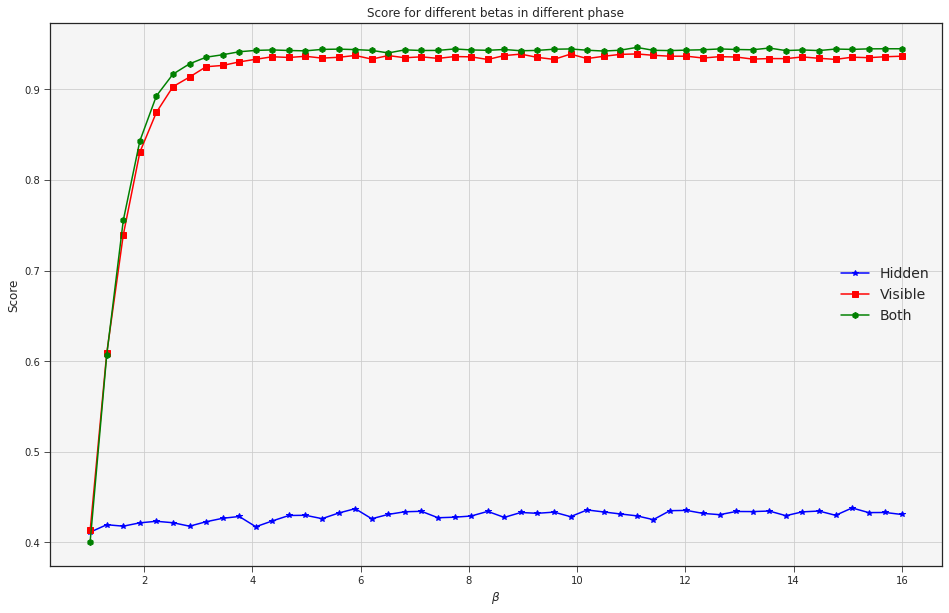

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(16,10))
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.title("Score for different betas in different phase")


plt.xlabel("$\\beta$", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.plot(betas,score_1,'b',label="Hidden",marker='*')
plt.plot(betas,score_2,'r',label="Visible",marker='s')
plt.plot(betas,score_both,'g',label="Both",marker='h')
plt.grid()
plt.legend(fontsize=14,loc="best")

plt.show()

We can see that the best method is the one with both the lower temperature both for the hidden and the visible fantasy data, but the sore is not much different from the one obtained just with the visible data. 

For the best $2$ methods, the score saturizes at around $\beta = 3$.

## 3) Introduction of a fifth state

In [ ]:
v, v_true, v0, N, L, GAP, vmin = import_data(0.1, 4, False)

DATA/dataRBM_q0.1_4state.csv
Each of N=10000 data samples has L=8 digits.
[1 1 0 0 1 1 0 0]
[1 1 0 0 0 1 1 0]
[0 1 0 1 1 1 0 0]
[0 0 1 1 0 0 1 1]
[1 1 0 1 1 1 1 1]
[1 1 1 1 0 1 1 1]
[0 0 1 1 1 0 1 1]
[0 0 1 1 1 1 0 0]
[1 1 0 0 1 1 0 0]
[0 0 0 1 1 0 1 1]
...


We have to find out the minimum number of hidden units M for the RBM to work properly. We set $\beta = 1$ in this case and we do a loop for different values of $M$, keeping track of the score.

In [ ]:
M = np.arange(3,15)
score_m4 = []

for i in M:
    w = sigma * (2*np.random.rand(L,i) - 1) #matrix of weights
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(i)

    w0,a0,b0 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    w0[:],a0[:],b0[:] = w[:],a[:],b[:]

    w1, a1, b1, _ = RBM(w, v, a, b, M = i, plot = False, ev = False)

    for n in range(N):
        h = activate(v0[n],w1,b1,GAP,β=1)
        v1[n] = activate(h,w1.T,a1,GAP,β=1)
    score_m4.append(comparison(v1, v_true, pixi))

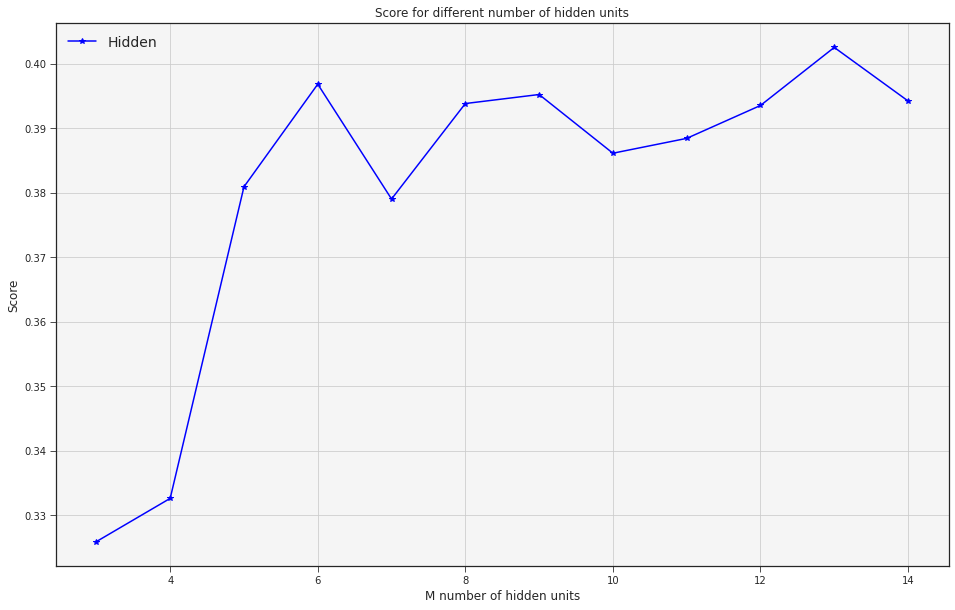

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(16,10))
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.title("Score for different number of hidden units")

plt.xlabel("M number of hidden units", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.plot(M,score_m4,'b',label="Hidden",marker='*')
plt.grid()
plt.legend(fontsize=14,loc="best")

plt.show()

We can see that the number of hidden units with the highest score is $8$.

Here we have introduced another state, the sixth. The analysis has been performed in the same as before.

In [ ]:
v, v_true, v0, N, L, GAP, vmin = import_data(0.1, 5, False)

DATA/dataRBM_q0.1_5state.csv
Each of N=10000 data samples has L=8 digits.
[1 1 0 0 1 1 0 0]
[1 1 0 0 0 1 1 0]
[0 1 0 1 1 1 0 0]
[0 0 1 1 0 0 1 1]
[1 1 0 1 1 1 1 1]
[1 1 1 1 0 1 1 1]
[0 0 1 1 1 0 1 1]
[0 0 1 1 1 1 0 0]
[1 1 0 0 1 1 0 0]
[0 0 0 1 1 0 1 1]
...


In [ ]:
score_m5 = []

for i in M:
    w = sigma * (2*np.random.rand(L,i) - 1) #matrix of weights
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(i)
    #print(f"w = {w}\na = {a}\nb = {b}")
    w0,a0,b0 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    w0[:],a0[:],b0[:] = w[:],a[:],b[:]

    w1, a1, b1, _ = RBM(w, v, a, b, M = i, plot = False, ev = False)

    for n in range(N):
        h = activate(v0[n],w1,b1,GAP,β=1)
        v1[n] = activate(h,w1.T,a1,GAP,β=1)
    score_m5.append(comparison(v1, v_true, pixi))

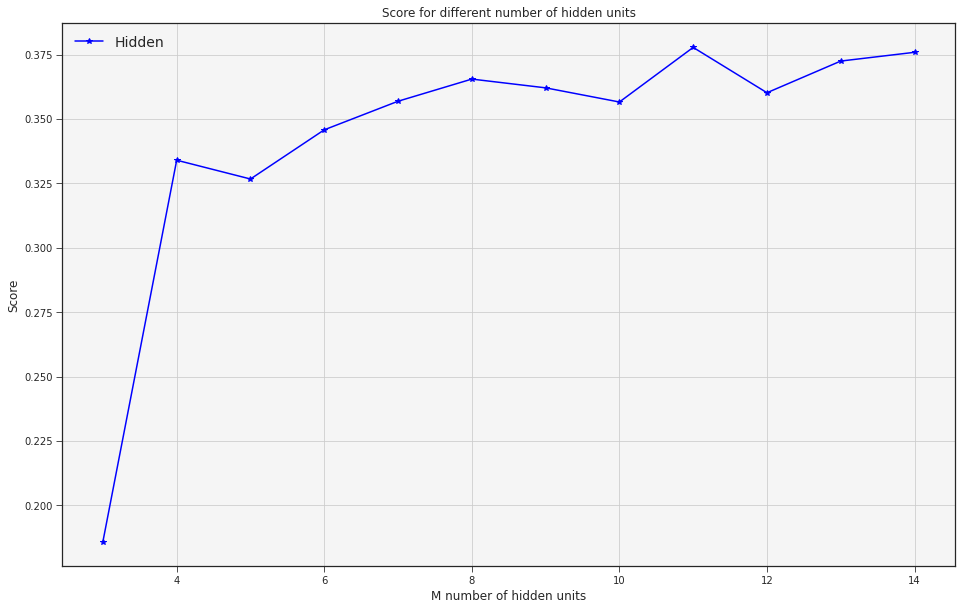

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(16,10))
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.title("Score for different number of hidden units")

plt.xlabel("M number of hidden units", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.plot(M,score_m5,'b',label="Hidden",marker='*')
plt.grid()
plt.legend(fontsize=14,loc="best")

plt.show()

We can see that the number of hidden units with the highest score is $11$.

## 4) We repeated the previous steps using a corruption parameter q=0.2

In [ ]:
v, v_true, v0, N, L, GAP, vmin = import_data(0.2, 3, False)

DATA/dataRBM_q0.2_3state.csv
Each of N=10000 data samples has L=8 digits.
[0 1 1 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[1 1 1 0 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 1 0 1 0 0 0]
[1 1 1 0 1 1 0 0]
[1 1 0 0 0 1 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]
...


In [ ]:
# Number of hidden units
M = 3

# This is good, is written in the review the denom is prop to the lenght of M
sigma = np.sqrt(4. /float(L + M))
np.random.seed(12345)

# Numbers in [-sigma;sigma]
w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)
print(f"w = {w}\na = {a}\nb = {b}")
w0,a0,b0 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
w0[:],a0[:],b0[:] = w[:],a[:],b[:]

w = [[ 0.5181365  -0.22145941 -0.38120826]
 [-0.35631371  0.08167946  0.11523125]
 [ 0.56022559  0.18473853  0.3001927 ]
 [ 0.18521223  0.2987553   0.55635686]
 [-0.59290602 -0.47464594 -0.24277246]
 [ 0.18863898  0.373648    0.44886104]
 [ 0.56038609  0.26977468  0.17183171]
 [ 0.26225893 -0.03907707 -0.21035279]]
a = [-0.07279134  0.27701546  0.59580401  0.21331772  0.35074515 -0.39689234
 -0.57064124  0.36226014]
b = [0. 0. 0.]


In [ ]:
score_both = []
score_1 = []
score_2 = []

In [ ]:
w1, a1, b1, _ = RBM(w, v, a, b, M, plot=False, ev = False)

In [ ]:
for beta in betas:
    v1 = np.full((N,L),vmin)
    for n in range(N):
        h = activate(v0[n], w1, b1, GAP, β = beta)
        v1[n] = activate(h, w1.T, a1, GAP, β = beta)
    score_both.append(comparison(v1, v_true, pixi))

In [ ]:
for beta in betas:
    v1 = np.full((N,L),vmin)
    for n in range(N):
        h = activate(v0[n], w1, b1, GAP, β = beta)
        v1[n] = activate(h, w1.T, a1, GAP)
    score_1.append(comparison(v1, v_true, pixi))

In [ ]:
for beta in betas:
    v1 = np.full((N,L),vmin)
    for n in range(N):
        h = activate(v0[n], w1, b1, GAP)
        v1[n] = activate(h, w1.T, a1, GAP, β = beta)
    score_2.append(comparison(v1, v_true, pixi))

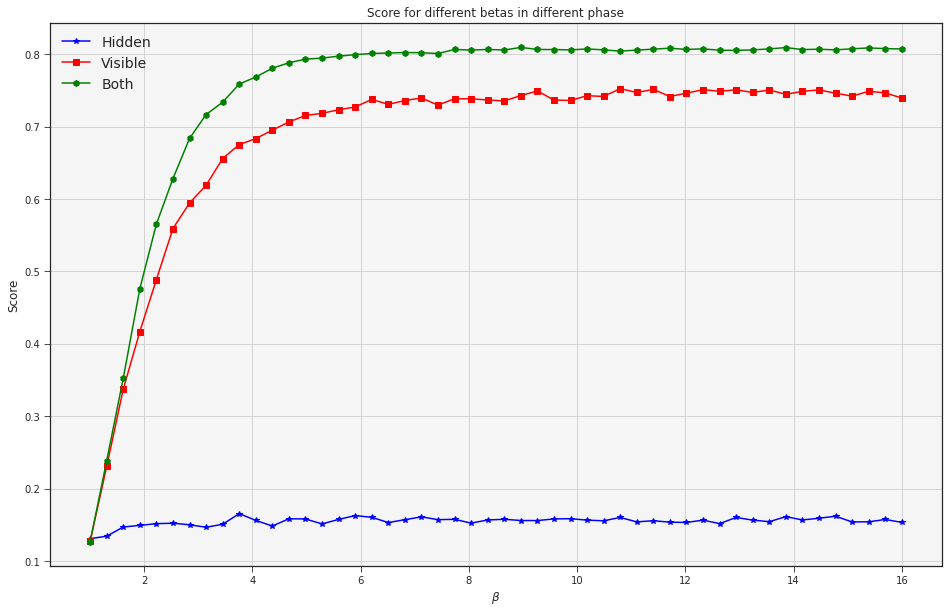

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(16,10))
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.title("Score for different betas in different phase")


plt.xlabel("$\\beta$", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.plot(betas,score_1,'b',label="Hidden",marker='*')
plt.plot(betas,score_2,'r',label="Visible",marker='s')
plt.plot(betas,score_both,'g',label="Both",marker='h')
plt.grid()
plt.legend(fontsize=14,loc="best")

plt.show()

We have a big grade of corruption. We notice that the score reached with high $\beta$ is smaller than the one obtained before.

Now we are going to introduce the fifth and the sixth state.

In [ ]:
v, v_true, v0, N, L, GAP, vmin = import_data(0.2, 4, False)

DATA/dataRBM_q0.2_4state.csv
Each of N=10000 data samples has L=8 digits.
[1 1 0 0 1 1 0 0]
[0 1 0 0 0 1 1 0]
[0 1 1 1 1 0 0 0]
[0 0 1 1 0 0 1 1]
[1 1 0 1 1 1 1 1]
[1 1 1 1 0 1 0 1]
[0 1 1 1 1 0 1 1]
[0 0 1 1 1 1 0 0]
[1 1 0 0 1 1 1 0]
[0 0 0 1 1 0 1 1]
...


In [ ]:
M = np.arange(3,15)
score_m4 = []

for i in M:
    w = sigma * (2*np.random.rand(L,i) - 1) #matrix of weights
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(i)

    w0,a0,b0 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    w0[:],a0[:],b0[:] = w[:],a[:],b[:]

    w1,a1,b1, _ = RBM(w, v, a, b, M = i, plot = False, ev= False)

    for n in range(N):
        h = activate(v0[n],w1,b1,GAP,β=1)
        v1[n] = activate(h,w1.T,a1,GAP,β=1)
    score_m4.append(comparison(v1, v_true, pixi))

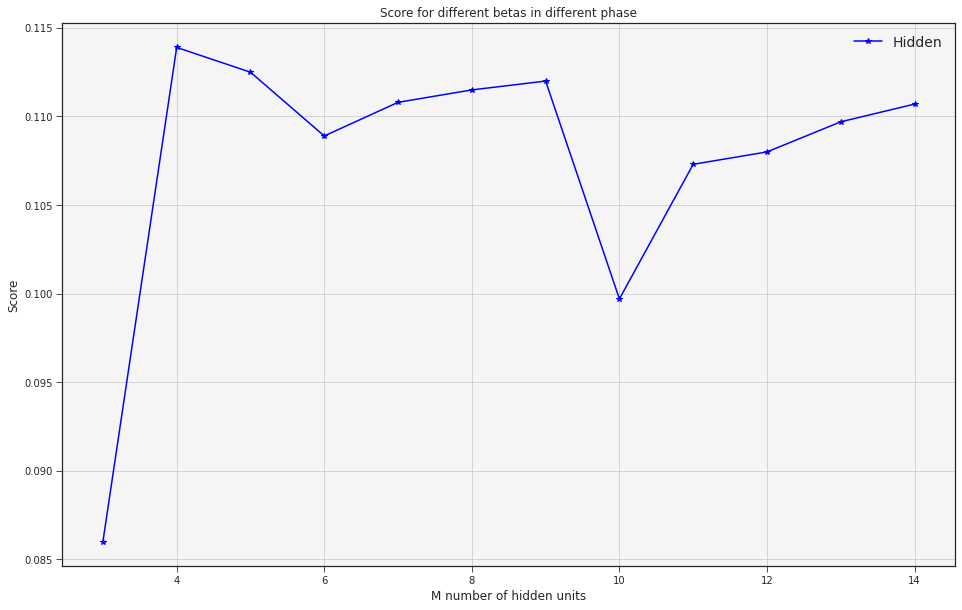

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(16,10))
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.title("Score for different betas in different phase")


plt.xlabel("M number of hidden units", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.plot(M,score_m4,'b',label="Hidden",marker='*')
plt.grid()
plt.legend(fontsize=14,loc="best")

plt.show()

We can see that the number of hidden units with the highest score is $4$.


In [ ]:
v, v_true, v0, N, L, GAP, vmin = import_data(0.2, 5, False)

DATA/dataRBM_q0.2_5state.csv
Each of N=10000 data samples has L=8 digits.
[1 1 0 0 1 1 0 0]
[0 1 0 0 0 1 1 0]
[0 1 1 1 1 0 0 0]
[0 0 1 1 0 0 1 1]
[1 1 0 1 1 1 1 1]
[1 1 1 1 0 1 0 1]
[0 1 1 1 1 0 1 1]
[0 0 1 1 1 1 0 0]
[1 1 0 0 1 1 1 0]
[0 0 0 1 1 0 1 1]
...


In [ ]:
score_m5 = []

for i in M:
    w = sigma * (2*np.random.rand(L,i) - 1) #matrix of weights
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(i)
    #print(f"w = {w}\na = {a}\nb = {b}")
    w0,a0,b0 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    w0[:],a0[:],b0[:] = w[:],a[:],b[:]

    w1,a1,b1, _ = RBM(w, v, a, b, M = i, plot = False, ev=False)

    for n in range(N):
        h = activate(v0[n],w1,b1,GAP,β=1)
        v1[n] = activate(h,w1.T,a1,GAP,β=1)
    score_m5.append(comparison(v1, v_true, pixi))

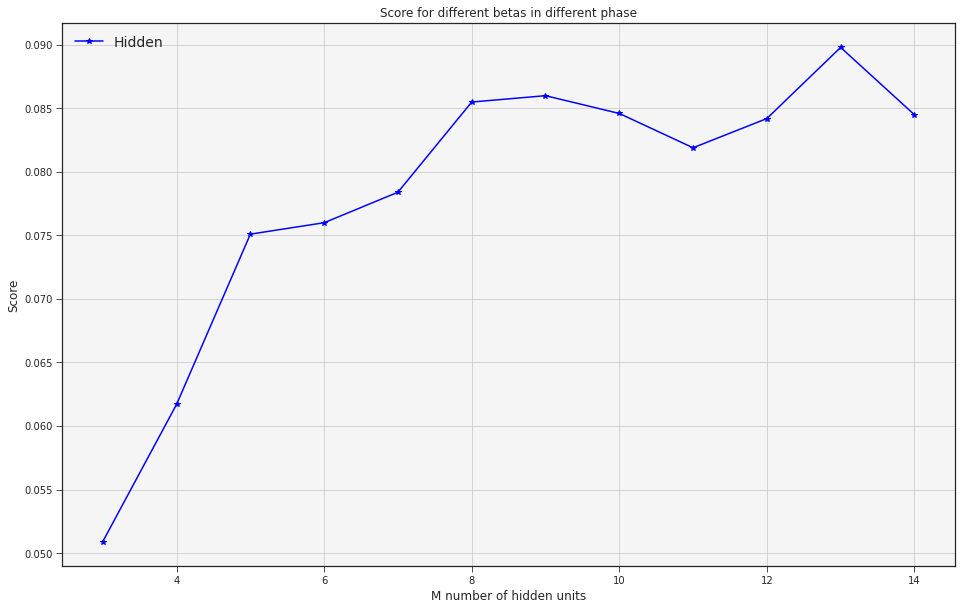

In [ ]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(16,10))
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.title("Score for different betas in different phase")


plt.xlabel("M number of hidden units", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.plot(M,score_m5,'b',label="Hidden",marker='*')
plt.grid()
plt.legend(fontsize=14,loc="best")

plt.show()

We can see that the number of hidden units with the highest score is $13$.

## 5) Compare convergence of RBM parameters with SPINS=True and SPINS=False

We are going to compare the convergence of RBM parameters for the case SPINS=True (i.e. using “spins”$(-1,1)$) and SPINS=False (using bits $ (0,1)$). We have decided to compare it showing the mean square increment of weights versus epochs.

In [ ]:
v, v_true, v0, N, L, GAP, vmin = import_data(0.1, 3, True)

DATA/dataRBM_q0.1_3state.csv
Each of N=10000 data samples has L=8 digits.
[-1  1 -1 -1  1 -1  1  1]
[ 1  1 -1  1  1 -1 -1  1]
[-1  1  1  1 -1 -1  1  1]
[-1 -1  1  1  1  1 -1 -1]
[-1 -1  1  1 -1 -1  1 -1]
[ 1  1 -1 -1  1 -1 -1 -1]
[-1  1  1 -1  1  1 -1 -1]
[ 1  1 -1 -1 -1 -1  1  1]
[ 1 -1 -1  1  1  1 -1  1]
[ 1 -1 -1 -1 -1 -1  1 -1]
...


In [ ]:
# Number of hidden units
M = 3

# This is good, is written in the review the denom is prop to the lenght of M
sigma = np.sqrt(4. /float(L + M))
np.random.seed(12345)

# Numbers in [-sigma;sigma]
w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)
print(f"w = {w}\na = {a}\nb = {b}")
w0,a0,b0 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
w0[:],a0[:],b0[:] = w[:],a[:],b[:]

score_both = []
score_1 = []
score_2 = []

w = [[ 0.5181365  -0.22145941 -0.38120826]
 [-0.35631371  0.08167946  0.11523125]
 [ 0.56022559  0.18473853  0.3001927 ]
 [ 0.18521223  0.2987553   0.55635686]
 [-0.59290602 -0.47464594 -0.24277246]
 [ 0.18863898  0.373648    0.44886104]
 [ 0.56038609  0.26977468  0.17183171]
 [ 0.26225893 -0.03907707 -0.21035279]]
a = [-0.07279134  0.27701546  0.59580401  0.21331772  0.35074515 -0.39689234
 -0.57064124  0.36226014]
b = [0. 0. 0.]


In [ ]:
w2, a2, b2, mean_dw_true = RBM(w, v, a, b, M, plot=False, ev = True)

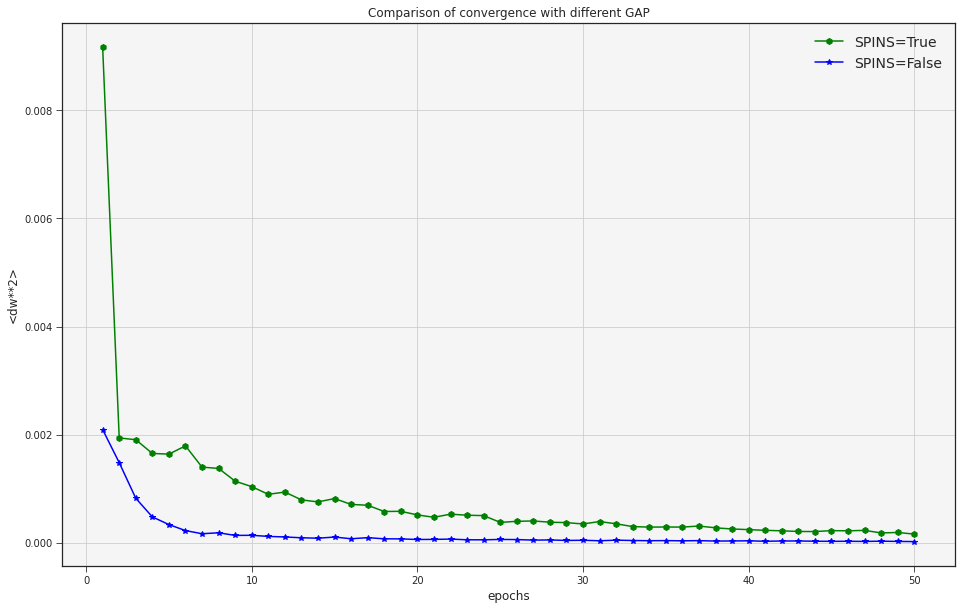

In [ ]:
epochs = np.arange(1,51)
plt.style.use('seaborn-ticks')
plt.figure(figsize=(16,10))
ax = plt.axes()
ax.set_facecolor("whitesmoke")
plt.title("Comparison of convergence with different GAP")

plt.xlabel("epochs", fontsize=12)
plt.ylabel("<dw**2>", fontsize=12)
plt.plot(epochs, mean_dw_true,'g',label="SPINS=True",marker='h')
plt.plot(epochs,mean_dw_false,'b',label="SPINS=False",marker='*')
plt.grid()
plt.legend(fontsize=14,loc="best")

plt.show()

## Conclusion

In the first and second point, the most important thing to visualize is that the score goes up with lower temperature (higher $\beta$), reaching a score almost equals to $1$. Also, there is not so much difference from the "Both" case and the "Visible" case. On the other hand, the "Hidden" case is not working, as expected.
Because of the high score reached, we have checked that the bit correction is working.

In the third point, we have noticed that with more states we need more hidden units. In the plot above, we can see that $M=3$ has a lower score compared to $M>3$. Anyway, the score seems stable with higher $M$. 

In the fourth point, we have introduced more corruption in the data starting from the basic number of hidden units M=3 and subsequently we have increased it up to M=6. This has lead rightly to smaller score respect to the q=0.1 case: the "Hidden" case is not working as before (lowest score), the "Both" one seems to be the best reaching a mean level of 0.8. 

In the fifth point, we have compared two different kind of data according to the SPINS value (True/False). In order to quantify the convercence of the different parameters we have considered the mean square increment of weights $<dw^2>$ . We have noticed that the case with SPINS=False (bits) seems to converge before  and in a better way respect to the other one. This is due to their GAP difference: the GAP parameter is releted to the activate function. With a smaller GAP, the difference between activated and de-acxtivate neurons is smaller and so the mean of the weights is closer to $0$. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc341315-a668-4e89-92e9-cab634ea884a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>